In [ ]:
dbutils.fs.put("dbfs:/FileStore/tables/cleandata.csv", "", overwrite=True)



Wrote 0 bytes.
Out[1]: True

In [ ]:
df = spark.read.format("csv").option("header", "true").load("/FileStore/tables/cleandata-1.csv")


In [ ]:
df.show()


+------+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
|    Id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|
+------+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
|150524|0006641040| ACITT7DI6IDDL|     shari zychinski|                   0|                     0|    1| 939340800|     everi book educ|witti littl book ...|
|150506|0006641040|A2IW4PEEKO2R0U|               Tracy|                   1|                     1|    1|1194739200|love book, miss h...|grew read sendak ...|
|150507|0006641040|A1S4A3IQ2MU7V4|"sally sue ""sall...|                   1|                     1|    1|1191456000|chicken soup rice...|fun way children ...|
|150508|0006641040|   AZGXZ2UUK6X|"Catherine H

In [ ]:
# PCA

In [ ]:
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

# Cast string columns that are actually numeric to the correct type
df = df.withColumn("HelpfulnessNumerator", col("HelpfulnessNumerator").cast(IntegerType()))
df = df.withColumn("HelpfulnessDenominator", col("HelpfulnessDenominator").cast(IntegerType()))
df = df.withColumn("Score", col("Score").cast(IntegerType()))
df = df.withColumn("Time", col("Time").cast(IntegerType()))

# Drop any rows that have null values in the columns of interest
df = df.dropna(subset=["HelpfulnessNumerator", "HelpfulnessDenominator", "Score", "Time"])

# Assemble the features into a vector
assembler = VectorAssembler(inputCols=["HelpfulnessNumerator", "HelpfulnessDenominator", "Score", "Time"], outputCol="features")
df_assembled = assembler.transform(df)

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# Apply PCA
pca = PCA(k=3, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(df_scaled)
pca_result = pca_model.transform(df_scaled)

# Show the resulting DataFrame
pca_result.select("pcaFeatures").show(truncate=False)


+----------------------------------------------------------+
|pcaFeatures                                               |
+----------------------------------------------------------+
|[4.9163173836421885,8.788522613218994,16.709771568951613] |
|[5.99191188822818,11.802165423581132,20.87997831128151]   |
|[5.975586028090823,11.76359449301826,20.827018026214333]  |
|[5.401603155893192,10.407521776386755,18.965045898589377] |
|[4.633022716299758,9.766699343717809,18.155952150975697]  |
|[6.929553715317411,13.544927366314226,23.240610932761896] |
|[6.899909390331156,13.47489067660796,23.1444462046136]    |
|[6.837613345070186,13.32771212577595,22.942360906330954]  |
|[6.778754322996027,13.188653770851907,22.751425141746658] |
|[6.725480463600439,13.062790734278327,22.578607369422187] |
|[6.0718226773215624,11.990959978441506,21.139204969768215]|
|[6.679080650578475,12.953168089520691,22.42808866449442]  |
|[6.651154837185626,12.88719149776841,22.3374987031953]    |
|[6.494770282185673,12.5

# Each row in the pcaFeatures column represents the principal components for a corresponding row in your original dataset. These principal components are the transformed coordinates in the new feature space that PCA has created.

# Since  k=3 for PCA, each row has three values, corresponding to the first three principal components. These components capture the most significant variance in your dataset while reducing the number of dimensions.

# Interpreting the Results
# Principal Components: Each value in the pcaFeatures array represents a principal component. The first number is the first principal component, the second number is the second principal component, and so on.

# Dimensionality Reduction: PCA has transformed your original multi-dimensional data into a 3-dimensional space. This can help with visualizing complex datasets, feeding into other machine learning algorithms, or identifying inherent patterns in the data.

# Variance Explained: These principal components are oriented in the direction of maximum variance in the dataset. The first principal component captures the most variance, followed by the second, and so on.

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field pcaFeatures. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


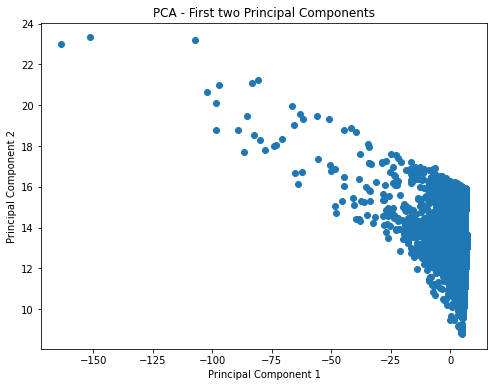

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the PCA results to a Pandas DataFrame
pca_df = pca_result.select("pcaFeatures").toPandas()

# Extract the individual components for plotting
pca_df["PC1"] = pca_df["pcaFeatures"].apply(lambda x: x[0])
pca_df["PC2"] = pca_df["pcaFeatures"].apply(lambda x: x[1])

# Plot the first two principal components
plt.figure(figsize=(8,6))
plt.scatter(pca_df["PC1"], pca_df["PC2"])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - First two Principal Components')
plt.show()


**Principal Component 1 (PC1):** This is the horizontal axis of the plot, representing the direction of maximum variance in the data. It's where the data varies the most.

**Principal Component 2 (PC2):** The vertical axis represents the second direction of maximum variance, which is orthogonal (at a right angle) to the first principal component.

**Data Spread**: The spread of the points shows how your data is distributed along these two principal components. It looks like there's a concentration of data points towards the right side of the plot, indicating that a lot of your data shares similar values in the dimensions captured by PC1 and PC2.

**Clustering or Patterns:** The plot doesn't show distinct clusters, but there's a clear trend where the data points spread out more as they move from right to left along PC1. This could indicate a gradient or a continuous relationship in the dataset. For example, in a dataset of customer purchases, this might represent different types of customer spending behavior.

**Outliers:** There are a few points that stand out from the main concentration of data, particularly along the PC1 axis. These could be outliers or special cases within your dataset that are worth investigating further.

**Insights:** The plot can provide insights into the underlying structure of the data. It might suggest that most of the variation in the dataset can be explained by a few key underlying factors. However, without more context about what each feature represents, it’s hard to say what these factors might be.

In [ ]:
# t-SNE

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field scaledFeatures. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/databricks/python/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 362435 samples in 0.404s...
[t-SNE] Computed neighbors for 362435 samples in 41.745s...
[t-SNE] Computed conditional probabilities for sample 1000 / 362435
[t-SNE] Computed conditional probabilities for sample 2000 / 362435
[t-SNE] Computed conditional probabilities for sample 3000 / 362435
[t-SNE] Computed conditional probabilities for sample 4000 / 362435
[t-SNE] Computed conditional probabilities for sample 5000 / 362435
[t-SNE] Computed conditional probabilities for sample 6000 / 362435
[t-SNE] Computed conditional probabilities for sample 7000 / 362435
[t-SNE] Computed conditional probabilities for sample 8000 / 362435
[t-SNE] Computed conditional probabilities for sample 9000 / 362435
[t-SNE] Computed conditional probabilities for sample 10000 / 362435
[t-SNE] Computed conditional probabilities for sample 11000 / 362435
[t-SNE] Computed conditional probabilities for sample 12000 / 362435
[t-SNE] Computed conditional proba

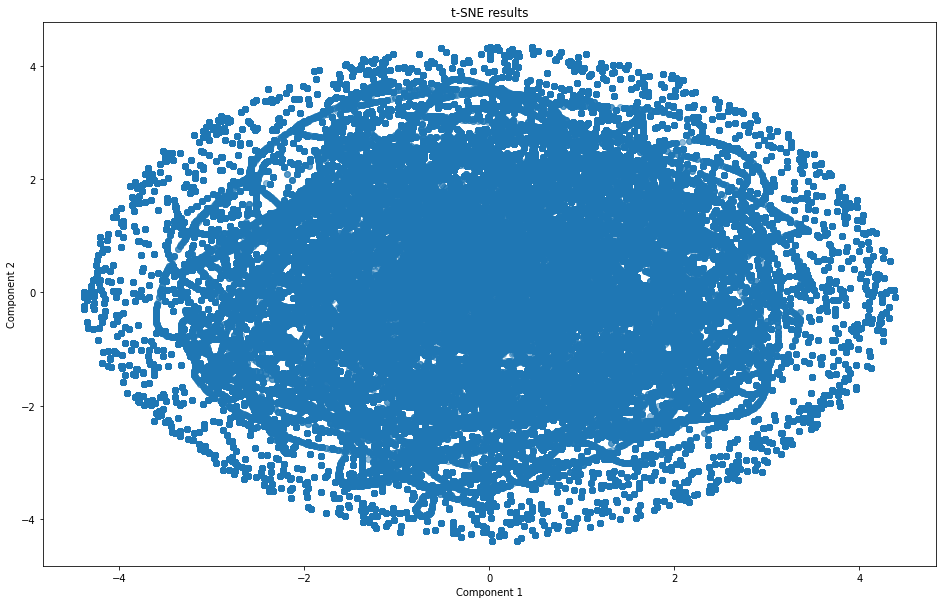

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df_scaled' is your Spark DataFrame with the scaled features
# Convert the scaled features to a pandas DataFrame
# Note: Use a sample if the dataset is too large to fit in memory
pdf = df_scaled.select('scaledFeatures').toPandas()

# Extract the feature vectors for t-SNE
X = pd.DataFrame(pdf['scaledFeatures'].tolist())

# Perform t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

# Plot the results
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha=0.5)
plt.title('t-SNE results')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


**Data Distribution:** The visualization shows a torus-like pattern, suggesting the data might have a circular or cyclical nature when reduced to two dimensions.

**Clusters and Density:** No distinct clusters are evident; instead, there's a density gradient from the center outwards, implying varying densities within the high-dimensional space.
Data Relationships: The uninterrupted structure hints at a smooth transition between different states or groups in the dataset rather than distinct, isolated categories.

**Insights:** This visualization could help guide further analysis, such as indicating periodic behavior for time-based data or suggesting a lack of clear boundaries between different categories.

**Perplexity and Iteration Parameters:** The visual pattern can vary with different t-SNE settings, potentially highlighting or hiding data structures.
Random Initialization: t-SNE's sensitivity to initialization means that different runs may yield different patterns; consistent patterns across runs are more trustworthy.

**Distance Preservation:** t-SNE is good at preserving local structures, but not global distances, meaning close points in the plot are likely similar, but distant points aren't necessarily dissimilar.